### Ce-bigFISH: image analysis toolkit for single embryo

#### Input image info:

In [1]:
folder_name = '/pl/active/onishimura_lab/PROJECTS/naly/bigfish/01_RNAi_quantification/wLP017-ERM-1/wLP017_L4440_RNAi/240820_wLP017_L4440_erm-1_set-3-rep1/input/03' #your folder should contain 2 images (.dv and its ref.dv)

# User-defined channel names (set to None if the channel does not exist)
Cy5 = "set-3 mRNA"  # (Q670)
mCherry = "erm-1 mRNA"  # (Q610)
FITC = "nothing"  # (GFP)
DAPI = "DAPI"
brightfield = "brightfield"


#info about your microscope
wavelength_cy5 = 670 # emmision peak in nm
wavelength_mCherry = 610  # emmision peak in nm
na = 1.42  # numerical aperture of microscope
refractive_index_medium = 1.515 # oil refractive index

voxel_size = (1448, 450, 450)   # Microscope pixel size Z,Y,X


In [2]:
#import packages:
import os
import matplotlib.pyplot as plt
import numpy as np

import tifffile
import bigfish
import bigfish.stack as stack
import bigfish.plot as plot
import bigfish.multistack as multistack
import bigfish.detection as detection

import cellpose
from cellpose import models
# from cellpose import plot
import pandas as pd
import skimage
from skimage.measure import label, regionprops
from skimage.morphology import square, dilation,erosion
from skimage import measure, morphology
from skimage.morphology import disk, binary_erosion


from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib.units import inch
from PIL import Image

import plotly.graph_objects as go
from skimage.morphology import disk, binary_erosion

from skimage.transform import resize
from matplotlib.colors import ListedColormap


import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import cv2
import tifffile

# pip install nd2
# pip install plotly
# pip install ipywidgets
# pip install ipympl

from mpl_toolkits.mplot3d import Axes3D



#### Image dimensions sanity check:

In [3]:
# Reading the microscopy data
current_directory = os.getcwd()
folder_path = os.path.join(current_directory, folder_name)

if os.path.exists(folder_path):
    # List the files in the folder
    list_filenames = os.listdir(folder_path)
    list_filenames = sorted(list_filenames)
    path_files = [os.path.join(folder_path, filename) for filename in list_filenames if not filename.startswith('.ipynb_checkpoints')]

    # Read DV files and store image stacks in list_images
    list_images = []
    for image in path_files:
        image_stack = stack.read_dv(image)
        list_images.append(image_stack)

# Extract Image ID by removing the "_R3D_REF.dv" suffix
dv_filename = list_filenames[1]
if dv_filename.endswith("_R3D_REF.dv"):
    image_name = dv_filename[:-len("_R3D_REF.dv")]
else:
    image_name = dv_filename  # In case the suffix is different, just keep the original name
print(f'Image ID: {image_name}', '\n')

# Converting the image to a specific shape
bf = list_images[1] # [C,Z,Y,X]
image_colors = list_images[0] # Reference [Y,X]

bf = bf.astype(np.uint16)
image_colors = image_colors.astype(np.uint16)

# print(f'Image files: {list_filenames}', '\n')
print(f'Image colors \n{list_filenames[0]}: {image_colors.shape} \n')
print(f'Brightfield \n{list_filenames[1]}: {bf.shape}')
# print(f'Image_colors: {image_colors.shape}')

Image ID: 240820_wLP017_L4440_03 

Image colors 
240820_wLP017_L4440_03_R3D.dv: (4, 66, 1024, 1024) 

Brightfield 
240820_wLP017_L4440_03_R3D_REF.dv: (1024, 1024)


In [4]:
# # #Plot in 3D
# # #240730 - ok, this was nice but can only show one z stack at a time. still trying to import plotly to plot in 3D

# # Select a middle slice along the Z-axis
# img = image_colors[1, :, :, :]
# z_slice = img.shape[0] // 2
# img_slice = img[z_slice, :, :]

# # Create meshgrid for X and Y coordinates
# x = np.arange(img_slice.shape[1])
# y = np.arange(img_slice.shape[0])
# x, y = np.meshgrid(x, y)

# # Z values are the intensity values of the image slice
# z = img_slice

# fig = plt.figure(figsize=(12, 10))
# ax = fig.add_subplot(180, projection='3d')
# surf = ax.plot_surface(x, y, z, cmap='viridis')

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Intensity')
# ax.set_title('3D Visualization of Channel')

# plt.colorbar(surf)
# plt.show()


In [5]:
# import napari
# import numpy as np

# # Assuming image_colors is a 4D array (channels, z, x, y)
# img = image_colors[2, :, :, :]  # Select a channel

# viewer = napari.Viewer()
# viewer.add_image(img, colormap='gray')
# napari.run()


In [6]:
# from skimage import data

# import napari

# blobs = data.binary_blobs(length=64, volume_fraction=0.1, n_dim=3).astype(
#     float
# )
# viewer = napari.Viewer(ndisplay=3)
# # add the volume
# viewer.add_image(blobs, scale=[3, 1, 1])

# if __name__ == '__main__':
#     napari.run()

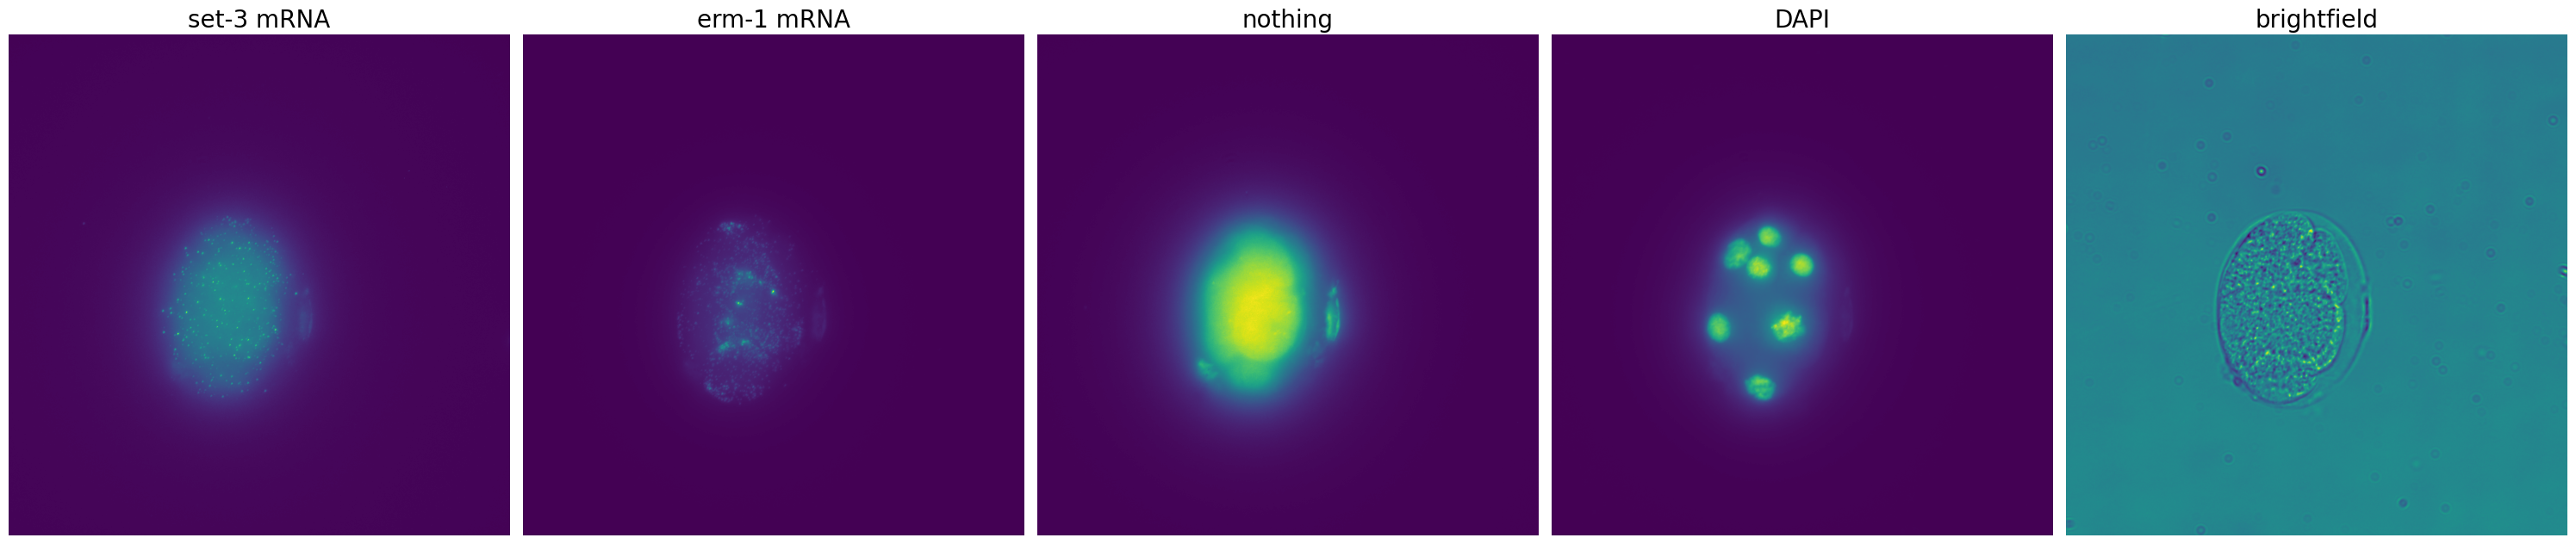

In [7]:
# Create output folder if it doesn't exist
output_folder = folder_name + "_results"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# List of channel names and their corresponding images
channels = [Cy5, mCherry, FITC, DAPI, brightfield]
titles = [Cy5, mCherry, FITC, DAPI, brightfield]
images = [
    np.max(image_colors[0, :, :, :], axis=0) if image_colors[0] is not None and Cy5 else None,
    np.max(image_colors[1, :, :, :], axis=0) if image_colors[1] is not None and mCherry else None,
    np.max(image_colors[2, :, :, :], axis=0) if image_colors[2] is not None and FITC else None,
    np.max(image_colors[3, :, :, :], axis=0) if image_colors[3] is not None and DAPI else None,
    bf if brightfield is not None else None
]

# Filter out None entries
filtered_images = [(img, title) for img, title in zip(images, titles) if img is not None]

fig, ax = plt.subplots(1, len(filtered_images), figsize=(6 * len(filtered_images), 8))

# Ensure ax is always iterable, even if there's only one plot
if len(filtered_images) == 1:
    ax = [ax]

for i, (img, title) in enumerate(filtered_images):
    ax[i].imshow(img)
    ax[i].set_title(title, size=20)
    ax[i].axis('off')

# Adjust layout if necessary
plt.tight_layout()

# Save the plots in the results folder
plt.savefig(os.path.join(output_folder, 'colors_' + image_name + '.png'))

plt.show()


### 1. Segmentation

#### 1.1 Single cell segmentation (up to 4-cell embryos)

In [8]:
# Additional functions used for segmentation
def is_nucleus_in_cytosol(mask_n, mask_c):
    mask_n[mask_n>1]=1
    mask_c[mask_c>1]=1
    size_mask_n = np.count_nonzero(mask_n)
    size_mask_c = np.count_nonzero(mask_c)
    min_size =np.min( (size_mask_n,size_mask_c) )
    mask_combined =  mask_n + mask_c
    sum_mask = np.count_nonzero(mask_combined[mask_combined==2])
    if (sum_mask> min_size*0.8) and (min_size>200): # the element is inside if the two masks overlap over the 80% of the smaller mask.
        return 1
    else:
        return 0
    
def remove_lonely_masks(masks_0, masks_1,is_nuc=None):
    n_mask_0 = np.max(masks_0)
    n_mask_1 = np.max(masks_1)
    if (n_mask_0>0) and (n_mask_1>0):
        for ind_0 in range(1,n_mask_0+1):
            tested_mask_0 = erosion(np.where(masks_0 == ind_0, 1, 0))
            array_paired= np.zeros(n_mask_1)
            for ind_1 in range(1,n_mask_1+1):
                tested_mask_1 = erosion(np.where(masks_1 == ind_1, 1, 0))
                array_paired[ind_1-1] = is_nucleus_in_cytosol(tested_mask_1, tested_mask_0)
                if (is_nuc =='nuc') and (np.count_nonzero(tested_mask_0) > np.count_nonzero(tested_mask_1) ):
                    # condition that rejects images with nucleus bigger than the cytosol
                    array_paired[ind_1-1] = 0
                elif (is_nuc is None ) and (np.count_nonzero(tested_mask_1) > np.count_nonzero(tested_mask_0) ):
                    array_paired[ind_1-1] = 0
            if any (array_paired) == False: # If the cytosol is not associated with any mask.
                masks_0 = np.where(masks_0 == ind_0, 0, masks_0)
            masks_with_pairs = masks_0
    else:
        masks_with_pairs = np.zeros_like(masks_0)
    return masks_with_pairs

def matching_masks(masks_cyto, masks_nuclei):
    n_mask_cyto = np.max(masks_cyto)
    n_mask_nuc = np.max(masks_nuclei)
    new_masks_nuclei = np.zeros_like(masks_cyto)
    reordered_mask_nuclei = np.zeros_like(masks_cyto)
    if (n_mask_cyto>0) and (n_mask_nuc>0):
        for mc in range(1,n_mask_cyto+1):
            tested_mask_cyto = np.where(masks_cyto == mc, 1, 0)
            for mn in range(1,n_mask_nuc+1):
                mask_paired = False
                tested_mask_nuc = np.where(masks_nuclei == mn, 1, 0)
                mask_paired = is_nucleus_in_cytosol(tested_mask_nuc, tested_mask_cyto)
                if mask_paired == True:
                    if np.count_nonzero(new_masks_nuclei) ==0:
                        new_masks_nuclei = np.where(masks_nuclei == mn, -mc, masks_nuclei)
                    else:
                        new_masks_nuclei = np.where(new_masks_nuclei == mn, -mc, new_masks_nuclei)
            reordered_mask_nuclei = np.absolute(new_masks_nuclei)
    return reordered_mask_nuclei

def remove_extreme_values(image,min_percentile=0.1, max_percentile=99.5):
    max_val = np.percentile(image, max_percentile)
    min_val = np.percentile(image, min_percentile)
    image [image < min_val] = min_val
    image [image > max_val] = max_val
    return image

def metric_max_cells_and_area( masks):
    n_masks = np.max(masks)
    if n_masks > 1: # detecting if more than 1 mask are detected per cell
        size_mask = []
        for nm in range (1, n_masks+1): # iterating for each mask in a given cell. The mask has values from 0 for background, to int n, where n is the number of detected masks.
            approximated_radius = np.sqrt(np.sum(masks == nm)/np.pi)  # a=  pi r2
            size_mask.append(approximated_radius) #np.sum(masks == nm)) # creating a list with the size of each mask
        size_masks_array = np.array(size_mask)
        metric = np.mean(size_masks_array).astype(int) * n_masks
    elif n_masks == 1: # do nothing if only a single mask is detected per image.
        approximated_radius = np.sqrt(np.sum(masks == 1)/np.pi) 
        metric = approximated_radius.astype(int)
    else:  # return zero if no mask are detected
        metric = 0  
    return metric   

def nuclear_segmentation(image_nuclei):
    MIN_CELL_SIZE = 1000
    list_masks_nuclei = []
    list_thresholds = np.arange(0.7,0.95, 0.05)
    array_number_detected_masks = np.zeros(len(list_thresholds))
    for i,tested_ts in enumerate(list_thresholds):
        image_nuclei_binary = image_nuclei.copy()
        max_value_image = np.max(image_nuclei_binary)
        image_nuclei_binary[image_nuclei_binary < max_value_image*tested_ts] = 0
        image_nuclei_binary[image_nuclei_binary > max_value_image*tested_ts] = 1
        labels = measure.label(image_nuclei_binary)
        filtered_labels = morphology.remove_small_objects(labels, min_size=MIN_CELL_SIZE)
        unique_filtered_labels = np.unique(filtered_labels)
        tested_masks_nuclei = np.zeros_like(filtered_labels)
        for idx, old_label in enumerate(unique_filtered_labels):
            tested_masks_nuclei[filtered_labels == old_label] = idx
        list_masks_nuclei.append(tested_masks_nuclei)
        array_number_detected_masks[i]= metric_max_cells_and_area( tested_masks_nuclei) 
    selected_index = np.argmax(array_number_detected_masks)
    masks_nuclei = list_masks_nuclei [selected_index]
    return masks_nuclei

def cytosol_segmentation(image_cytosol,second_image_cytosol,cytosol_diameter):
    flow_ts=1
    MIN_CELL_SIZE = 1000
    model = models.Cellpose(gpu=True, model_type='cyto2') # model_type='cyto', 'cyto2' or model_type='nuclei'
    if not (second_image_cytosol is None):
        merged_image_cytosol = np.concatenate((image_cytosol[:, :, np.newaxis], second_image_cytosol[:, :, np.newaxis]), axis=2)
        masks_cytosol_unfiltered = model.eval(merged_image_cytosol, diameter=cytosol_diameter, flow_threshold=flow_ts, channels=[0,1])[0]
    else:
        masks_cytosol_unfiltered = model.eval(image_cytosol, diameter=cytosol_diameter, flow_threshold=flow_ts, channels=[0,0])[0]
    filtered_cyto = morphology.remove_small_objects(masks_cytosol_unfiltered, min_size=MIN_CELL_SIZE)
    unique_filtered_cyto = np.unique(filtered_cyto)
    masks_cytosol = np.zeros_like(filtered_cyto)
    for idx, old_label in enumerate(unique_filtered_cyto):
        masks_cytosol[filtered_cyto == old_label] = idx
    return masks_cytosol



In [9]:
def segmentation_optimization(image_cytosol,image_nuclei,cytosol_diameter,second_image_cytosol=None):
    # Cytosol segmentation
    masks_cytosol =cytosol_segmentation(image_cytosol,second_image_cytosol,cytosol_diameter)
    # Nuclear segmentation
    masks_nuclei = nuclear_segmentation(image_nuclei)
    # reordering nuclei masks
    masks_nuclei = matching_masks(masks_cytosol,masks_nuclei)
    # remove masks without nuclei
    masks_nuclei= remove_lonely_masks(masks_0=masks_nuclei , masks_1=masks_cytosol,is_nuc='nuc')
    masks_cytosol= remove_lonely_masks(masks_0=masks_cytosol , masks_1=masks_nuclei)
    # calculate size of masks
    number_masks_cyto = np.max(masks_cytosol)
    list_masks_cyto_sizes =[]
    for i in range (1, number_masks_cyto+1):
        list_masks_cyto_sizes.append(len(masks_cytosol[masks_cytosol==i]) )
    number_masks_nuc = np.max(masks_nuclei)
    list_masks_nuc_sizes =[]
    for i in range (1, number_masks_nuc+1):
        list_masks_nuc_sizes.append(len(masks_nuclei[masks_nuclei==i]) )
    return masks_nuclei, masks_cytosol,list_masks_nuc_sizes, list_masks_cyto_sizes

In [10]:
# Codes used to segment the nucleus and the cytosol
def segmentation(image_cytosol,image_nuclei, second_image_cytosol=None):
    # removing outliers in image
    image_cytosol = remove_extreme_values(image=image_cytosol,min_percentile=0.1, max_percentile=99.5)
    if not (second_image_cytosol is None):
        second_image_cytosol = remove_extreme_values(image=second_image_cytosol,min_percentile=0.1, max_percentile=99.5)
    image_nuclei = remove_extreme_values(image=image_nuclei,min_percentile=0.1, max_percentile=99.5)
    # Optimization segmentation
    list_masks_nuclei = []
    list_masks_cytosol=[]
    list_masks_nuc_sizes =[]
    list_masks_cyto_sizes=[]
    list_flow_thresholds = np.arange(40, 200, 10)
    array_number_detected_masks = np.zeros(len(list_flow_thresholds))
    for i,tested_ts in enumerate(list_flow_thresholds):
        tested_masks_nuclei, tested_masks_cytosol, tested_list_masks_nuc_sizes, tested_list_masks_cyto_sizes = segmentation_optimization(image_cytosol,image_nuclei,cytosol_diameter=tested_ts,second_image_cytosol=second_image_cytosol)
        list_masks_nuclei.append(tested_masks_nuclei)
        list_masks_cytosol.append(tested_masks_cytosol)
        list_masks_nuc_sizes.append(tested_list_masks_nuc_sizes)
        list_masks_cyto_sizes.append(tested_list_masks_cyto_sizes)
        array_number_detected_masks[i]= metric_max_cells_and_area( tested_masks_cytosol) + metric_max_cells_and_area( tested_masks_nuclei)
    selected_index = np.argmax(array_number_detected_masks)
    masks_nuclei = list_masks_nuclei [selected_index]
    masks_cytosol = list_masks_cytosol [selected_index]
    masks_nuc_sizes = list_masks_nuc_sizes[selected_index]
    masks_cyto_sizes = list_masks_cyto_sizes[selected_index]
    
        # Plotting
    color_map = 'Greys_r'
    fig, ax = plt.subplots(1,4, figsize=(14, 4))
    # Plotting the heatmap of a section in the image
    ax[0].imshow(image_nuclei,cmap=color_map)
    ax[1].imshow(masks_nuclei,cmap=color_map)
    ax[2].imshow(image_cytosol,cmap=color_map)
    ax[3].imshow(masks_cytosol,cmap=color_map)
    ax[0].set(title='DAPI'); ax[0].axis('off');ax[0].grid(False)
    ax[1].set(title='mask nuclei'); ax[1].axis('off');ax[1].grid(False)
    ax[2].set(title='brightfield'); ax[2].axis('off');ax[2].grid(False)
    ax[3].set(title='mask cytosol'); ax[3].axis('off');ax[3].grid(False)
    
    return masks_cytosol, masks_nuclei, masks_cyto_sizes, masks_nuc_sizes

/tmp/ipykernel_3110894/1281690999.py:111: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  filtered_cyto = morphology.remove_small_objects(masks_cytosol_unfiltered, min_size=MIN_CELL_SIZE)


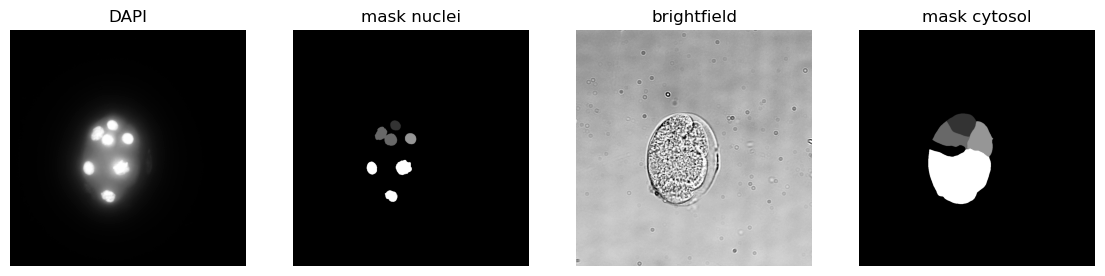

In [11]:
# # Run segmentation functions

image_nuclei = np.max(image_colors[3, :, :, :], axis=0)
image_cytosol = bf
second_image_cytosol = np.max(image_colors[3,:,:,:],axis=0 )
masks_cytosol, masks_nuclei,list_masks_cyto_sizes, list_masks_nuc_sizes = segmentation(image_cytosol,image_nuclei,second_image_cytosol)

segmentation_filename = os.path.join(output_folder, 'segmentation_' + image_name + '.png')

# Ensure the directory exists
# os.makedirs(segmentation_filename, exist_ok=True)

# Save the figure
plt.savefig(segmentation_filename)

#### 1.2 Interactive segmentation (manual for each embryo)

In [12]:
# # #Manual and interactive segmentation
# import ipywidgets as widgets
# from IPython.display import display
# import numpy as np
# import matplotlib.pyplot as plt
# import cv2
# import tifffile

# class ManualSegmentation():
#     '''
#     Create a mask object from user-drawn polygons. The image format must be [Y, X].
    
#     Parameters:
#     image : NumPy array
#         Image with dimensions [Y, X].
#     cmap : str
#         Color map to use for the image display. Default is 'Spectral'.
#     polygon_color : tuple 
#         RGB color of the polygon as a tuple (255, 0, 0).
#     '''

#     def __init__(self, image, cmap='Spectral', polygon_color=(255, 0, 0)):
#         self.ipython = get_ipython()
#         if self.ipython:
#             self.ipython.run_line_magic('matplotlib', 'widget')

#         self.image = self.process_image(image)
#         self.polygon_color = polygon_color
#         self.selected_points = []

#         self.figure_to_draw_points, self.axes_in_figure = plt.subplots(figsize=(5, 5))
#         self.new_image = self.axes_in_figure.imshow(self.image, cmap=cmap)

#         self.click = self.figure_to_draw_points.canvas.mpl_connect('button_press_event', self.onclick)

#     def process_image(self, image):
#         processed_image = RemoveExtrema(image, min_percentile=0.1, max_percentile=99).remove_outliers()
#         processed_image = (processed_image - processed_image.min()) / (processed_image.max() - processed_image.min()) * 255
#         return processed_image

#     def polygon(self, new_image, points_in_polygon):
#         points_in_polygon = np.array(points_in_polygon, np.int32)
#         points_in_polygon = points_in_polygon.reshape((-1, 1, 2))
#         cv2.polylines(new_image, [points_in_polygon], isClosed=True, color=self.polygon_color, thickness=3)
#         return new_image

#     def switch_to_inline(self):
#         if self.ipython:
#             self.ipython.run_line_magic('matplotlib', 'inline')
#         plt.show()  # Ensure that any existing plots are displayed
#         return None

#     def onclick(self, event):
#         if event.xdata is not None and event.ydata is not None:
#             self.selected_points.append([int(event.xdata), int(event.ydata)])
#             updated_image = self.polygon(np.copy(self.image), self.selected_points)
            
#             for point in self.selected_points:
#                 cv2.circle(updated_image, tuple(point), radius=3, color=self.polygon_color, thickness=-1)
            
#             self.new_image.set_data(updated_image)
#         return None

#     def close_and_save(self, filename='temp_mask.tif', save_mask=True):
#         if self.selected_points:
#             # Create an empty array with the same shape as the image slice
#             mask = np.zeros(self.image.shape[:2], dtype=np.uint8)

#             # Convert selected points to a numpy array for cv2.fillPoly
#             mask_array = np.array([self.selected_points], dtype=np.int32)

#             # Create the mask
#             cv2.fillPoly(mask, mask_array, 255)  # Fill with white (255)

#             if save_mask:
#                 # Save the mask as a tif file
#                 tifffile.imwrite(filename, mask, dtype='uint8')
#                 print(f'Mask saved as {filename}')

#             # Close the figure and disconnect the click
#             self.figure_to_draw_points.canvas.mpl_disconnect(self.click)
#             plt.close(self.figure_to_draw_points)
#             plt.close()

#             self.switch_to_inline()  # Switch back to inline when closing the plot
#             return mask.astype(bool)
#         else:
#             print('No points selected to create a mask.')
#             plt.close()
#             return None


# # Example usage:
# mask_object = ManualSegmentation(
#     image=np.max(image_colors[3,:,:,:],axis=0), 
#     cmap='Spectral'
# )  # NOTICE THAT FOR THE MASK SELECTION WE USE THE GREEN CHANNEL (channel 1)





### 2. Spot detection

#### 2.1 Spot detection (automated threshold selection and spot detection)

In [13]:
#@title Codes used for spot detection
# Note: spot radius = Point Spread Function (PSF)

def spot_detection(rna,voxel_size,spot_radius,masks_cytosol):
    spots, threshold = detection.detect_spots(
        images= rna,
        return_threshold=True,
        voxel_size=voxel_size,
        spot_radius=spot_radius) 

    spot_radius_px = detection.get_object_radius_pixel(
        voxel_size_nm=voxel_size,
        object_radius_nm=spot_radius,
        ndim=3) 

    # LoG filter
    rna_log = stack.log_filter(rna, sigma=spot_radius_px)

    # local maximum detection
    mask = detection.local_maximum_detection(rna_log, min_distance=spot_radius_px)

    # thresholding
    threshold = detection.automated_threshold_setting(rna_log, mask)
    spots, _ = detection.spots_thresholding(rna_log, mask, threshold)


    # Decompose regions by simulating as many spots as possible until we match the original region intensity.
    #spots_post_decomposition = spots.copy()
    spots_post_decomposition, dense_regions, reference_spot = detection.decompose_dense(
        image=rna,
        spots=spots,
        voxel_size=voxel_size,
        spot_radius=spot_radius,
        alpha=0.7,  # alpha impacts the number of spots per candidate region
        beta=1,  # beta impacts the number of candidate regions to decompose
        gamma=5)  # gamma the filtering step to denoise the image

    # define clusters
    spots_post_clustering, clusters = detection.detect_clusters(
        spots=spots_post_decomposition,
        voxel_size=voxel_size,
        radius=626, #626
        nb_min_spots=10)

    #plotting
#     print(f"Image ID: {image_name} \n")
    print(f"{rna_channel} detection")
    print(f" threshold: {threshold}")
    print("\r spots: {0}".format(spots_post_clustering.shape[0]))
    print("\r clusters: {0}".format(clusters.shape[0]))
   
        #elbow plot
    threshold_output = os.path.join(output_folder, rna_channel + '_threshold_' + image_name)
    plot.plot_elbow(
        images=rna,
        voxel_size=voxel_size,
        spot_radius=spot_radius,
        size_axes=8,
        framesize=(5, 3),
        title=(f"{rna_channel} detection threshold"),
        size_title=12,
        path_output=threshold_output,
        show=True  # Set show to False to hide the plot
    )



    #    # Save the plots in the results folder
    detection_output = os.path.join(output_folder, rna_channel + '_detection_' + image_name)
    plot.plot_detection(
        image=np.max(rna, axis=0),
        spots=[spots_post_decomposition, clusters[:, :3]],
        shape=["circle", "polygon"],
        radius=[1, 4],
        color=detection_color,
        linewidth=[3, 2],
        fill=[False, True],
        contrast=True,
        framesize=(10, 5),
        title=(f"{rna_channel} detection"),
        path_output= detection_output,
        show=True
    )

    #spots_no_ts, _, ts = multistack.remove_transcription_site(spotDetectionCSV, clusterDetectionCSV, mask_nuc, ndim=3)
    #spots_in_region, _ = multistack.identify_objects_in_region(mask, spots_post_clustering[:,:3], ndim=3)

    # Separating and counting the spots in each cell
    number_masks_cyto = np.max(masks_cytosol)
    list_spots_in_each_cell =[]
    list_clusters_in_each_cell =[]
    for i in range (1, number_masks_cyto+1):
        temp_cyto_mask= np.zeros_like(masks_cytosol)
        temp_cyto_mask[masks_cytosol == i] = i
        spots_in_region, _ = multistack.identify_objects_in_region(mask=temp_cyto_mask, coord=spots_post_clustering[:,:3], ndim=3)
        clusters_in_region,_ = multistack.identify_objects_in_region(mask=temp_cyto_mask, coord=clusters[:,:3], ndim=3)
        list_spots_in_each_cell.append(len(spots_in_region))
        list_clusters_in_each_cell.append(len( clusters_in_region ))
        del spots_in_region, clusters_in_region
    return spots_post_clustering, clusters, list_spots_in_each_cell, list_clusters_in_each_cell

In [14]:
# PSF calculator 
wavelength_mCherry = 610  # wavelength in nm -> specified above
wavelength_cy5 = 670  # wavelength in nm -> specified above
na = 1.42  # numerical aperture -> specified above
refractive_index_medium = 1.515  # refractive index of imaging medium (oil)


# #ch1 - mCherry channel
# Calculate lateral PSF
fwhm_xy = 0.61 * wavelength_mCherry / na
# Calculate axial PSF
fwhm_z = 2 * refractive_index_medium * wavelength_mCherry / na**2
# # Print the result
# print(f"Lateral (xy) PSF: {fwhm_xy} nm")
# print(f"Axial (z) PSF with 60x oil objective: {fwhm_z} nm")


# #ch0 - Cy5 channel
# Calculate lateral PSF for Cy5 channel
fwhm_xy_cy5 = 0.61 * wavelength_cy5 / na
# Calculate axial PSF for Cy5 channel
fwhm_z_cy5 = 2 * refractive_index_medium * wavelength_cy5 / na**2
# # Print the result for Cy5 channel
# print(f"Lateral (xy) PSF for Cy5 channel: {fwhm_xy_cy5} nm")
# print(f"Axial (z) PSF for Cy5 channel with 60x oil objective: {fwhm_z_cy5} nm")


set-3 mRNA detection
 threshold: 175.0
 spots: 1016
 clusters: 0


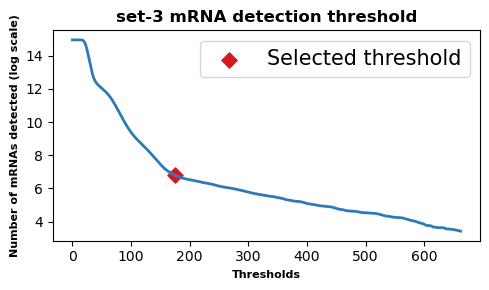

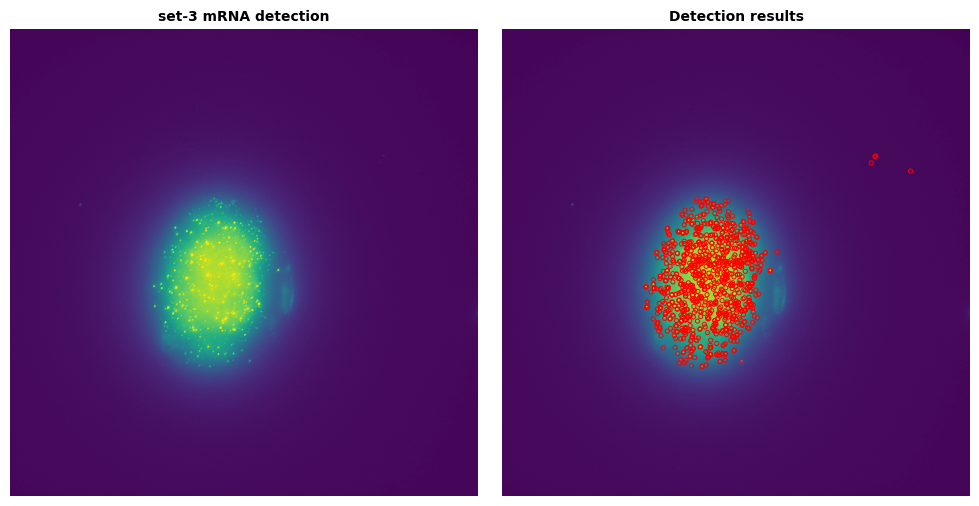

erm-1 mRNA detection
 threshold: 75.0
 spots: 3082
 clusters: 0


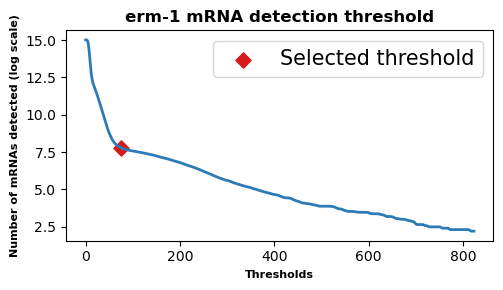

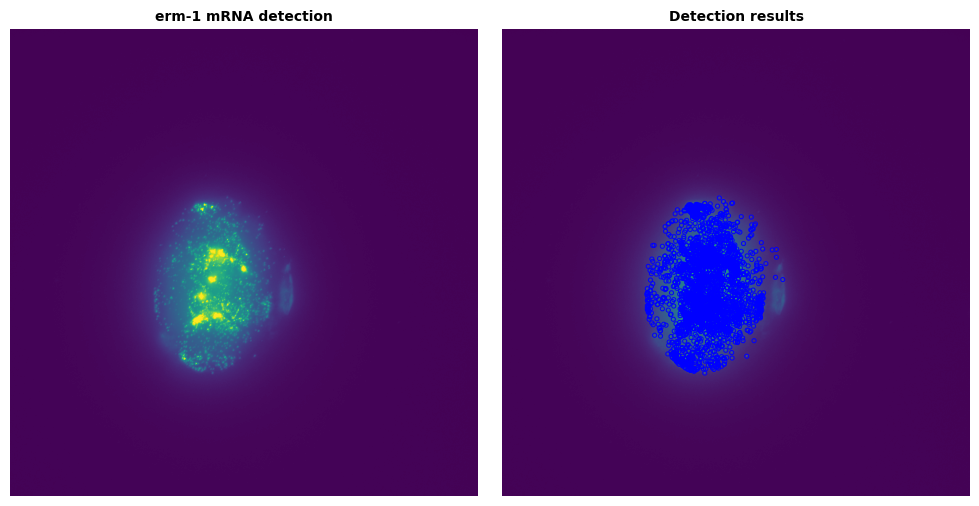

In [15]:
voxel_size = (1448, 450, 450)   # Microscope pixel size Z,Y,X
spot_radius_ch0 = (1006, 287, 287)  # PSF Z,Y,X
spot_radius_ch1 = (1283, 310, 310)  # PSF Z,Y,X


if Cy5 is not None and image_colors[0,:,:,:] is not None:
    rna_ch0 = image_colors[0,:,:,:] # [Z,Y,X,C]
#     rna_ch0 = rna_ch0.astype(np.uint16)
    rna_channel = Cy5
    detection_color = "red"
    spots_post_clustering_ch0, clusters_ch0,list_spots_in_each_cell_ch0,list_clusters_in_each_cell_ch0 = spot_detection(rna_ch0,voxel_size,spot_radius_ch0,masks_cytosol)

if mCherry is not None and image_colors[1,:,:,:] is not None:
    rna_ch1 = image_colors[1,:,:,:] # [Z,Y,X,C]
#     rna_ch1 = rna_ch1.astype(np.uint16)
    rna_channel = mCherry
    detection_color = "blue"
    spots_post_clustering_ch1, clusters_ch1,list_spots_in_each_cell_ch1,list_clusters_in_each_cell_ch1 = spot_detection(rna_ch1,voxel_size,spot_radius_ch1,masks_cytosol)



#### 2.2 Save mRNA counts as a dataframe

In [16]:
# Export as csv
df_quantification = pd.DataFrame()

# Calculate the sum of each list if they are not None
if 'list_spots_in_each_cell_ch0' in locals() and list_spots_in_each_cell_ch0 is not None:
    sum_spots_ch0 = sum(list_spots_in_each_cell_ch0)
    sum_clusters_ch0 = sum(list_clusters_in_each_cell_ch0) if 'list_clusters_in_each_cell_ch0' in locals() and list_clusters_in_each_cell_ch0 is not None else None
else:
    sum_spots_ch0 = None
    sum_clusters_ch0 = None

if 'list_spots_in_each_cell_ch1' in locals() and list_spots_in_each_cell_ch1 is not None:
    sum_spots_ch1 = sum(list_spots_in_each_cell_ch1)
    sum_clusters_ch1 = sum(list_clusters_in_each_cell_ch1) if 'list_clusters_in_each_cell_ch1' in locals() and list_clusters_in_each_cell_ch1 is not None else None
else:
    sum_spots_ch1 = None
    sum_clusters_ch1 = None

# Check if any sum is not None and skip appending to df_quantification if all are None
if any(x is not None for x in [sum_spots_ch0, sum_clusters_ch0, sum_spots_ch1, sum_clusters_ch1]):
    # Create a data dictionary with summed values
    data = {
        'Image ID': image_name,
    }

    if sum_spots_ch0 is not None or sum_clusters_ch0 is not None:
        data[f'{Cy5} molecules'] = sum_spots_ch0
#         data[f'{Cy5} mRNA clusters'] = sum_clusters_ch0

    if sum_spots_ch1 is not None or sum_clusters_ch1 is not None:
        data[f'{mCherry} molecules'] = sum_spots_ch1
#         data[f'{mCherry} mRNA clusters'] = sum_clusters_ch1

    # Concatenate the data as a new row to the DataFrame
    df_quantification = pd.concat([df_quantification, pd.DataFrame([data])], ignore_index=True)

    quantification_output = os.path.join(output_folder, 'quantification_' + image_name + '.csv')

    # Save the DataFrame to CSV
    df_quantification.to_csv(quantification_output, index=False)

#     # Optionally, you can assign path_output to quantification_output if needed
#     path_output = quantification_output

# Display the DataFrame (optional)
df_quantification

# plot.plot_reference_spot(reference_spot, rescale=True)

,Image ID,set-3 mRNA molecules,erm-1 mRNA molecules
0,240820_wLP017_L4440_03,924,2815


#### 2.3 mRNA Abundance Heatmap

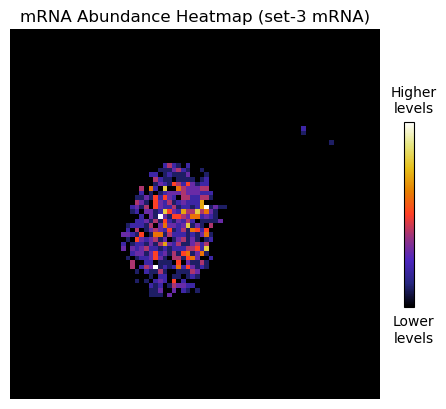

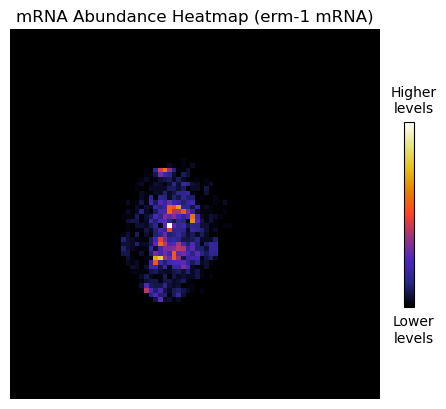

In [17]:
# Generate heatmaps of mRNA abundance in each channel

def create_heatmap(spots_x, spots_y, masks_cytosol, masks_nuclei, output_filename, title_suffix, grid_width=80, grid_height=80):
    # Calculate the width and height of each grid cell
    img_width, img_height = masks_cytosol.shape[1], masks_cytosol.shape[0]
    cell_width = img_width / grid_width
    cell_height = img_height / grid_height

    # Create an empty grid to store the spot counts
    grid = np.zeros((grid_height, grid_width), dtype=int)

    # Count spots in each grid cell
    for x, y in zip(spots_x, spots_y):
        # Determine which grid cell the spot belongs to
        cell_x = int(x / cell_width)
        cell_y = int(y / cell_height)

        # Increment the count in the corresponding grid cell
        if 0 <= cell_x < grid_width and 0 <= cell_y < grid_height:
            grid[cell_y, cell_x] += 1

    # Create a heatmap
    plt.imshow(masks_cytosol, cmap='gray')  # Display the original image
    plt.imshow(masks_nuclei, cmap='gray')
    plt.imshow(grid, cmap='CMRmap', alpha=1, interpolation='nearest')  # Overlay the heatmap
    plt.title(f'mRNA Abundance Heatmap ({title_suffix})')
    plt.axis('off')

    # Create a vertical color bar
    cbar = plt.colorbar(orientation='vertical', shrink=0.5)  # Adjust the shrink parameter to make it smaller
    cbar.ax.text(1, 1.05, 'Higher\nlevels', transform=cbar.ax.transAxes, ha='center')
    cbar.ax.text(1, -0.19, 'Lower\nlevels', transform=cbar.ax.transAxes, ha='center')
    cbar.set_ticks([])

    # Save the plots in the results folder
    plt.savefig(output_filename)
    plt.show()

    # Return the grid for further processing
    return grid

# Initialize variables for storing the heatmaps
cy5_heatmap = None
mcherry_heatmap = None

# Generate heatmap for channel 0 (Cy5) if spots_post_clustering_ch0 is defined
if 'spots_post_clustering_ch0' in locals():
    spots_x_ch0 = spots_post_clustering_ch0[:, 2]
    spots_y_ch0 = spots_post_clustering_ch0[:, 1]
    cy5_heatmap = create_heatmap(spots_x_ch0, spots_y_ch0, masks_cytosol, masks_nuclei, os.path.join(output_folder, f'{Cy5}_heatmap.png'), Cy5)

# Generate heatmap for channel 1 (mCherry) if spots_post_clustering_ch1 is defined
if 'spots_post_clustering_ch1' in locals():
    spots_x_ch1 = spots_post_clustering_ch1[:, 2]
    spots_y_ch1 = spots_post_clustering_ch1[:, 1]
    mcherry_heatmap = create_heatmap(spots_x_ch1, spots_y_ch1, masks_cytosol, masks_nuclei, os.path.join(output_folder, f'{mCherry}_heatmap.png'), mCherry)



In [18]:
# #Tidy up before plotting

# Show reference image in 2D
#2D mRNA channel image for background
rna_max_ch0 = np.max(image_colors[0, :, :, :], axis=0)  # Cy5 channel
rna_max_ch1 = np.max(image_colors[1, :, :, :], axis=0)  # mCherry channel





# Clean arrays to calculate special features in 3D
ch0_array = spots_post_clustering_ch0
# Check if the array has exactly 4 columns
if ch0_array.shape[1] == 4 :
    # Remove the last column
    ch0_array = ch0_array[:, :-1]
#     print("Last column removed.")
else:
    # Keep the array unchanged
    ch0_array  = ch0_array
#     print("Array unchanged.")

# Display the cleaned array
# print("Cleaned ch0 array:")
# print(ch0_array)

print("\n")

# Original array (example)
ch1_array = spots_post_clustering_ch1
# Check if the array has exactly 4 columns 
if ch1_array.shape[1] == 4 :
    # Remove the last column
    ch1_array = ch1_array[:, :-1]
#     print("Last column removed.")
else:
    # Keep the array unchanged
    ch1_array = ch1_array
#     print("Array unchanged.")

# Display the cleaned array
# print("Cleaned ch1 array:")
# print(ch1_array)


### 3. Special Features

#### 3.1 mRNA-membrane colocalization 

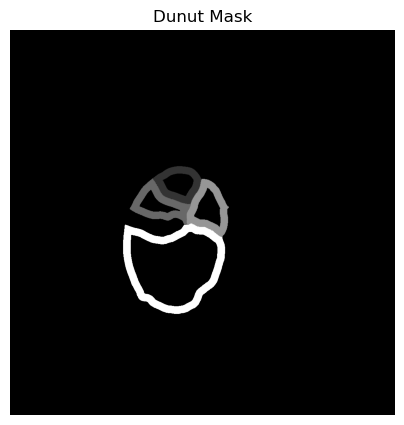

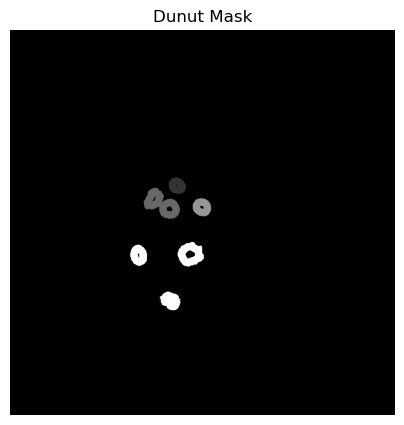

In [19]:
def generate_donut_mask(original_mask, n, plot=False):
    # Initialize the final mask
    donut_mask = np.zeros_like(original_mask)

    for i in np.unique(original_mask):
        if i == 0:
            continue  # Skip the background (assuming it's labeled as 0)
        
        selected_cel = original_mask == i

        # Erode the original mask by n pixels using a disk-shaped structuring element
        selem = disk(n)
        eroded_mask = binary_erosion(selected_cel, selem)

        # Create the border mask by subtracting the eroded mask from the original
        donut = selected_cel & ~eroded_mask
        donut_mask[donut] = i

    # Plotting the border mask if 'plot' is set to True
    if plot:
        plt.figure(figsize=(5, 5))
        plt.imshow(donut_mask, cmap='Greys_r')
        plt.title(f'Dunut Mask')
        plt.axis('off')
        plt.show()

    return donut_mask

# Example usage:
cytosol_donut_mask = generate_donut_mask(masks_cytosol, n=20, plot=True)
nuclei_donut_mask = generate_donut_mask(masks_nuclei, n=20, plot=True)


detected spots (on membranes)
 shape: (1107, 3)
 dtype: int64 

detected spots (in cyto)
 shape: (1975, 3)
 dtype: int64


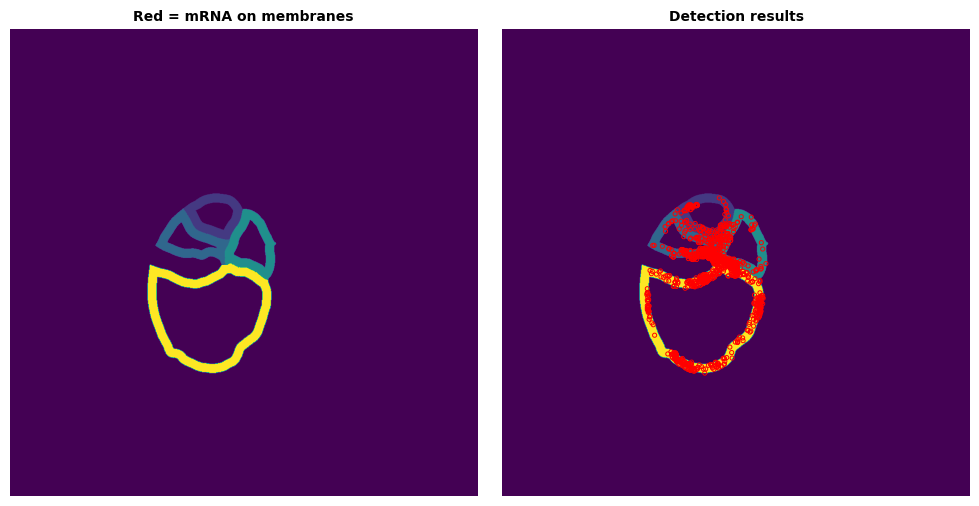

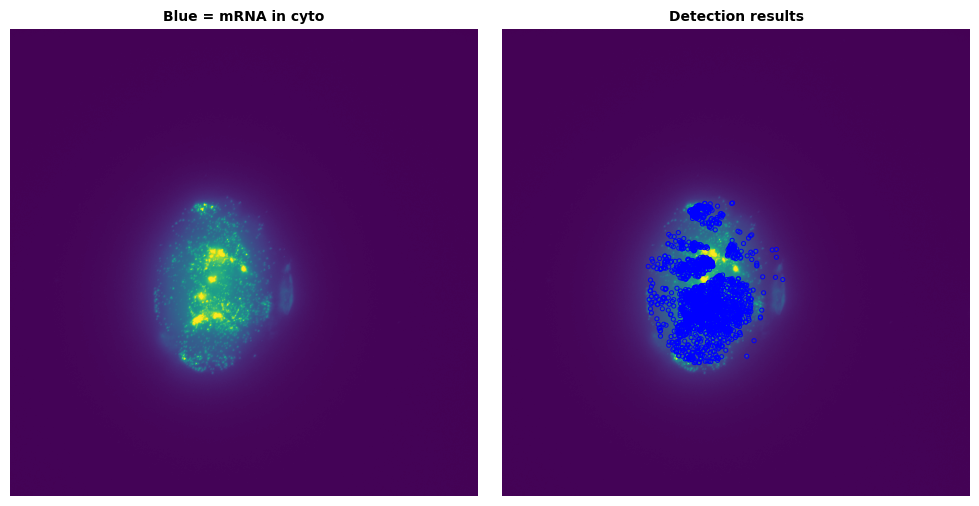

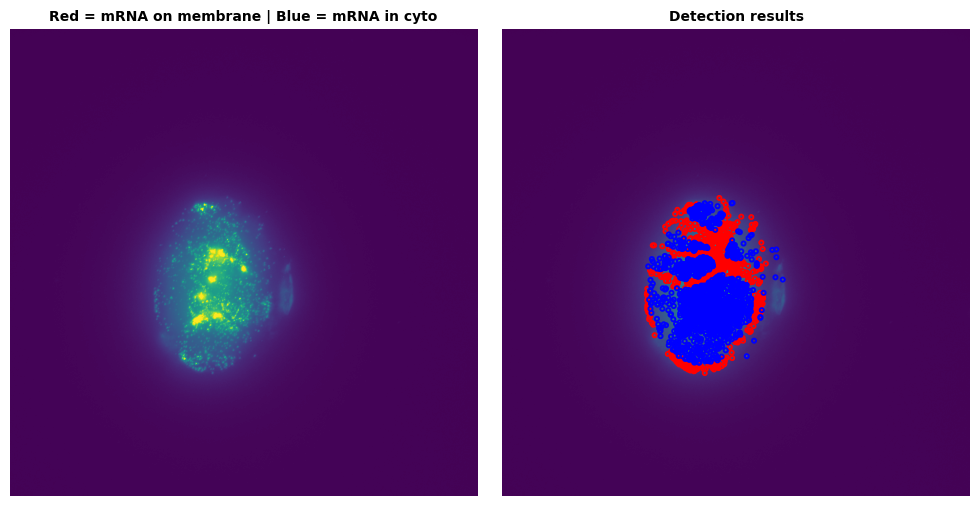

In [20]:
#Code to visualize colocalization with p granules

mask = cytosol_donut_mask
coord = ch1_array
ndim = 3

spots_in_membranes, spots_out_membranes = bigfish.multistack.identify_objects_in_region(mask, coord, ndim)

# spots_in, spots_out = multistack.identify_objects_in_region(nuc_label, spots, ndim=3)
print("detected spots (on membranes)")
print("\r shape: {0}".format(spots_in_membranes.shape))
print("\r dtype: {0}".format(spots_in_membranes.dtype), "\n")
print("detected spots (in cyto)")
print("\r shape: {0}".format(spots_out_membranes.shape))
print("\r dtype: {0}".format(spots_out_membranes.dtype))

in_membranes_output = os.path.join(output_folder, mCherry + '_in_membranes_' + image_name + '.png')
# plot
plot.plot_detection(
    mask,
    spots=spots_in_membranes, 
    radius=1, 
    color="red",
    path_output= in_membranes_output,
    title="Red = mRNA on membranes",
    linewidth=3, contrast=True, framesize=(10, 5))

out_membranes_output = os.path.join(output_folder, mCherry + '_out_membranes_' + image_name + '.png')
# plot
plot.plot_detection(
    rna_max_ch1,
    spots=spots_out_membranes, 
    radius=1, 
    color="blue",
    path_output= out_membranes_output,
    title="Blue = mRNA in cyto",
    linewidth=3, contrast=True, framesize=(10, 5))

combined_membranes_output = os.path.join(output_folder, mCherry + '_combined_membranes_output_' + image_name + '.png')
# plot
plot.plot_detection(
    rna_max_ch1,
    spots=[spots_in_membranes, spots_out_membranes], 
    radius=2, 
    color=["red", "blue"],
    path_output= combined_membranes_output,
    title=f"Red = mRNA on membrane | Blue = mRNA in cyto",
    linewidth=3, contrast=True, framesize=(10, 5))

In [21]:
# Quantification: number of spots in nuclei and cytoplasm
num_spots_in_membranes = spots_in_membranes.shape[0]
# num_spots_in_cyto = spots_out_pgranules.shape[0]

# Add new columns with default values (e.g., NaN)
df_quantification[f'{mCherry} in membranes'] = np.nan
# df_quantification['mCherry_out_pgranules'] = np.nan

# Update the new columns with the counts for the specific image ID
df_quantification.loc[df_quantification['Image ID'] == image_name, f'{mCherry} in membranes'] = num_spots_in_membranes
# df_quantification.loc[df_quantification['Image ID'] == image_name, 'mCherry_out_pgranules'] = num_spots_in_cyto

# Display the updated DataFrame
df_quantification


,Image ID,set-3 mRNA molecules,erm-1 mRNA molecules,erm-1 mRNA in membranes
0,240820_wLP017_L4440_03,924,2815,1107.0


In [22]:
# #Distance from the membrane
# from scipy.spatial import distance
# import numpy as np

# donut = cytosol_donut_mask

# # Check dimensions of coord and donut
# print(f"coord shape: {coord.shape}")
# print(f"donut shape: {donut.shape}")

# # Ensure both coord and donut are handled correctly based on their dimensions
# if coord.shape[1] == 3 and donut.ndim == 2:
#     # coord is 3D, donut is 2D
#     # Calculate the z-plane from coord to match it with the 2D donut mask
#     z_plane = round(np.median(coord[:, 2]))  # Median z-plane for stability
#     donut_coords = np.column_stack(np.where(donut > 0))
# elif coord.shape[1] == 3 and donut.ndim == 3:
#     # Both coord and donut are 3D
#     donut_coords = np.column_stack(np.where(donut > 0))
# else:
#     # Both coord and donut are 2D
#     donut_coords = np.column_stack(np.where(donut > 0))

# # Calculate the distance of each spot from the membrane boundary in the x-y plane
# distances = distance.cdist(coord[:, :2], donut_coords[:, :2])

# # Define a threshold distance for spillover detection (e.g., 10 pixels)
# threshold_distance = 10

# # Identify spots within the membrane
# spots_in_membranes = coord[distances.min(axis=1) <= threshold_distance]

# # Identify spots that are close to the membrane but might be spilling over
# spillover_spots = coord[(distances.min(axis=1) > threshold_distance) & (distances.min(axis=1) <= 2 * threshold_distance)]

# # Identify spots in the background
# background_spots = coord[distances.min(axis=1) > 2 * threshold_distance]

# # Debugging output to ensure the classification is working correctly
# print(f"Total spots: {len(coord)}")
# print(f"Spots in membranes: {len(spots_in_membranes)}")
# print(f"Spillover spots: {len(spillover_spots)}")
# print(f"Background spots: {len(background_spots)}")


# from scipy.spatial import distance
# import numpy as np

# # Check dimensions of coord and donut
# print(f"coord shape: {coord.shape}")
# print(f"donut shape: {donut.shape}")

# # Ensure that coord is 3D and donut is 2D
# if coord.shape[1] == 3 and donut.ndim == 2:
#     # Calculate the z-plane to align with the 2D donut mask
#     z_plane = round(np.median(coord[:, 2]))  # Median z-plane for stability
#     coord_in_plane = coord[coord[:, 2] == z_plane, :2]  # Select spots in the same z-plane
    
#     # Extract 2D coordinates where the donut mask is non-zero
#     donut_coords = np.column_stack(np.where(donut > 0))

#     # Calculate the distance of each spot in the z-plane from the membrane boundary
#     distances = distance.cdist(coord_in_plane, donut_coords)

#     # Define a threshold distance for spillover detection (e.g., 10 pixels)
#     threshold_distance = 10

#     # Identify spots within the membrane
#     spots_in_membranes = coord[distances.min(axis=1) <= threshold_distance]

#     # Identify spots that are close to the membrane but might be spilling over
#     spillover_spots = coord[(distances.min(axis=1) > threshold_distance) & (distances.min(axis=1) <= 2 * threshold_distance)]

#     # Identify spots in the background
#     background_spots = coord[distances.min(axis=1) > 2 * threshold_distance]

#     # Debugging output to ensure the classification is working correctly
#     print(f"Total spots: {len(coord)}")
#     print(f"Spots in membranes: {len(spots_in_membranes)}")
#     print(f"Spillover spots: {len(spillover_spots)}")
#     print(f"Background spots: {len(background_spots)}")

# else:
#     print("Unexpected dimensions: Ensure `coord` is 3D and `donut` is 2D.")



In [23]:
#gfp mask for co-localization


#### 3.2 Nuclear colocalization (transcription sites)

Detected spots (inside nuclei)
 shape: (562, 3)
Detected spots (in cyto)
 shape: (2520, 3)


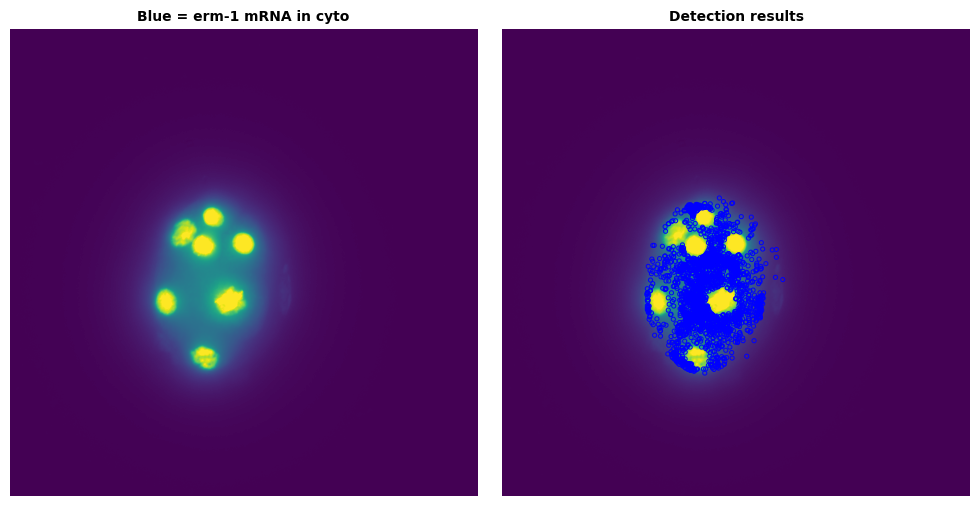

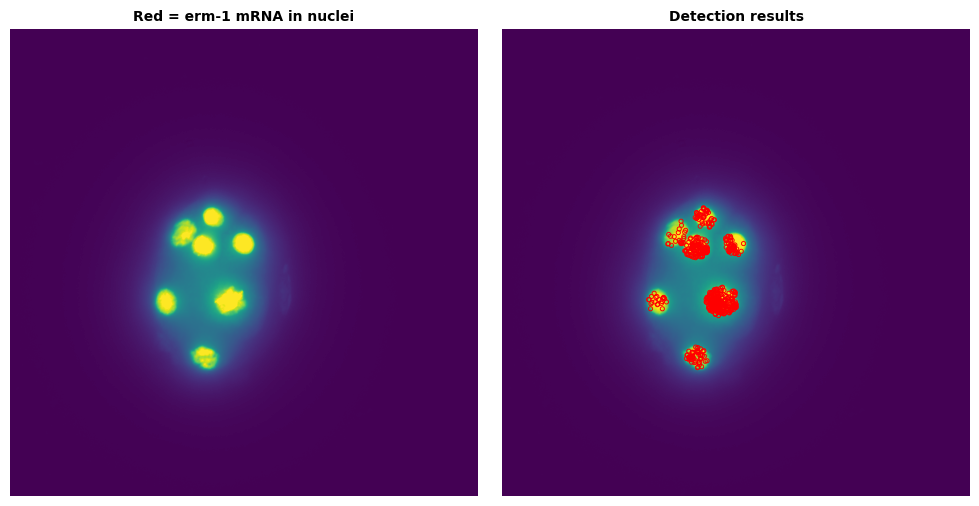

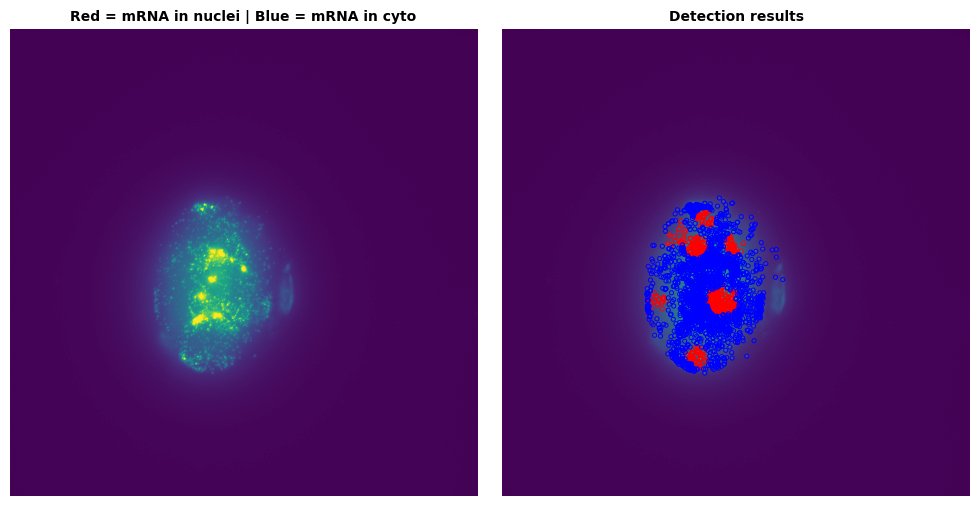

In [24]:
# masks_nuclei.shape # mask nuclei is a 2D array that contains the 3D data
nuc_max = np.max(image_colors[1, :, :, :], axis=0)  # mCherry channel


# # plot
# plot.plot_detection(
#     image_nuclei,
#     spots=[spots_in, spots_out], 
#     radius=1, 
#     color=["red", "blue"],
#     title=f"Red = {Cy5} | Blue = {mCherry}",
#     linewidth=3, contrast=True, framesize=(10, 5))


# Visualizing colocalization with nuclei
mask = masks_nuclei
coord = ch1_array
ndim = 3

spots_in, spots_out = bigfish.multistack.identify_objects_in_region(mask, coord, ndim)

# Output detected spots
print("Detected spots (inside nuclei)")
print("\r shape: {0}".format(spots_in.shape))

print("Detected spots (in cyto)")
print("\r shape: {0}".format(spots_out.shape))

# Plot and save each visualization
cyto_output = os.path.join(output_folder, mCherry + '_in_cyto_' + image_name + '.png')

# Plot mRNA in cytoplasm
plot.plot_detection(
    image_nuclei,
    spots=spots_out, 
    path_output= cyto_output,
    radius=1, 
    color="blue",
    title=f"Blue = {mCherry} in cyto",
    linewidth=3, contrast=True, framesize=(10, 5)
)

nuclei_output = os.path.join(output_folder, mCherry + '_in_nuclei_' + image_name + '.png')

# Plot mRNA in nuclei
plot.plot_detection(
    image_nuclei,
    spots=spots_in,
    path_output= nuclei_output,
    radius=1, 
    color="red",
    title=f"Red = {mCherry} in nuclei",
    linewidth=3, contrast=True, framesize=(10, 5)
)

combined_output = os.path.join(output_folder, mCherry + '_in_nuclei_and_cyto_' + image_name + '.png')

# Plot combined mRNA in nuclei and cytoplasm
plot.plot_detection(
    rna_max_ch1,
    spots=[spots_in, spots_out], 
    path_output= combined_output,
    radius=1, 
    color=["red", "blue"],
    title=f"Red = mRNA in nuclei | Blue = mRNA in cyto",
    linewidth=3, contrast=True, framesize=(10, 5)
)



In [25]:
# Quantification: number of spots in nuclei and cytoplasm
num_spots_in_nuclei = spots_in.shape[0]
num_spots_in_cyto = spots_out.shape[0]

# Add new columns with default values (e.g., NaN)
df_quantification[f'{mCherry} in nuclei'] = np.nan
# df_quantification['mCherry_in_cyto'] = np.nan

# Update the new columns for the specific image ID
df_quantification.loc[df_quantification['Image ID'] == image_name, f'{mCherry} in nuclei'] = num_spots_in_nuclei
# df_quantification.loc[df_quantification['Image ID'] == image_name, 'mCherry_in_cyto'] = num_spots_in_cyto

# Display the updated DataFrame
df_quantification

,Image ID,set-3 mRNA molecules,erm-1 mRNA molecules,erm-1 mRNA in membranes,erm-1 mRNA in nuclei
0,240820_wLP017_L4440_03,924,2815,1107.0,562.0


#### 3.3 mRNA-p granule colocalization 

In [26]:
#p-granule mask for co-localization

image_pgranules = np.max(image_colors[2, :, :, :], axis=0)

def mask_pgranule(image_pgranules):
    MIN_CELL_SIZE = 1
    list_masks_pgranules = []
    list_thresholds = np.arange(0.7,0.95, 0.05)
    array_number_detected_masks = np.zeros(len(list_thresholds))
    for i,tested_ts in enumerate(list_thresholds):
        image_pgranules_binary = image_pgranules.copy()
        max_value_image = np.max(image_pgranules_binary)
        image_pgranules_binary[image_pgranules_binary < max_value_image*tested_ts] = 0
        image_pgranules_binary[image_pgranules_binary > max_value_image*tested_ts] = 1
        labels = measure.label(image_pgranules_binary)
        filtered_labels = morphology.remove_small_objects(labels, min_size=MIN_CELL_SIZE)
        unique_filtered_labels = np.unique(filtered_labels)
        tested_masks_pgranules = np.zeros_like(filtered_labels)
        for idx, old_label in enumerate(unique_filtered_labels):
            tested_masks_pgranules[filtered_labels == old_label] = idx
        list_masks_pgranules.append(tested_masks_pgranules)
        array_number_detected_masks[i]= metric_max_cells_and_area( tested_masks_pgranules) 
    selected_index = np.argmax(array_number_detected_masks)
    masks_pgranules = list_masks_pgranules [selected_index]
    return masks_pgranules

masks_pgranules = mask_pgranule(image_pgranules)


# Plotting
color_map = 'Greys_r'
fig, ax = plt.subplots(1,4, figsize=(14, 4))
# Plotting the heatmap of a section in the image
ax[0].imshow(image_pgranules,cmap=color_map)
ax[1].imshow(masks_pgranules,cmap=color_map)
ax[2].imshow(image_cytosol,cmap=color_map)
ax[3].imshow(masks_cytosol,cmap=color_map)
ax[0].set(title='p granules'); ax[0].axis('off');ax[0].grid(False)
ax[1].set(title='mask p granules'); ax[1].axis('off');ax[1].grid(False)
ax[2].set(title='brightfield'); ax[2].axis('off');ax[2].grid(False)
ax[3].set(title='mask cytosol'); ax[3].axis('off');ax[3].grid(False)

# Save the figure

output_path = os.path.join(output_folder, mCherry + '_pgranule_mask_' + image_name + '.png')

plt.savefig(output_path, bbox_inches='tight', pad_inches=0.1)

# Close the figure
plt.close()

# print(f"p-granule mask saved to {output_path}")


detected spots (inside p-granules)
 shape: (953, 3)
 dtype: int64 

detected spots (outside p-granules)
 shape: (2129, 3)
 dtype: int64


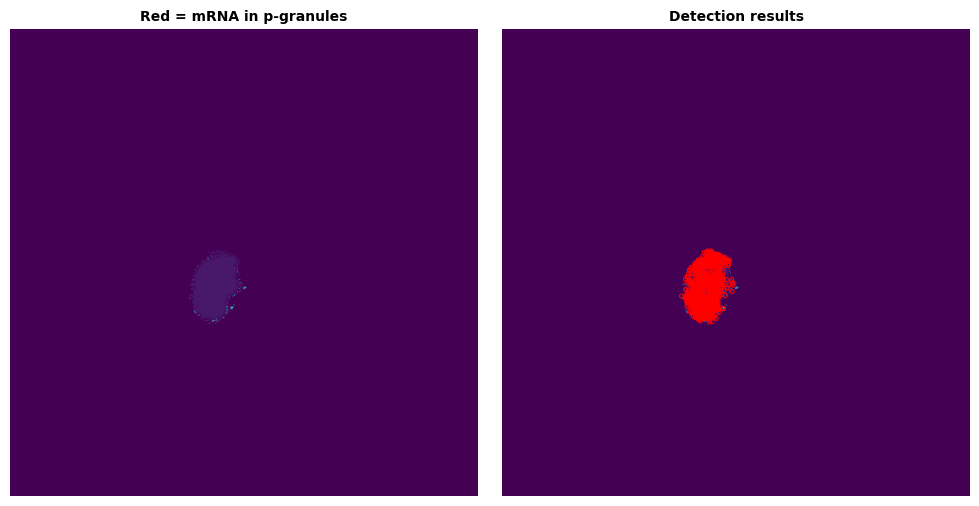

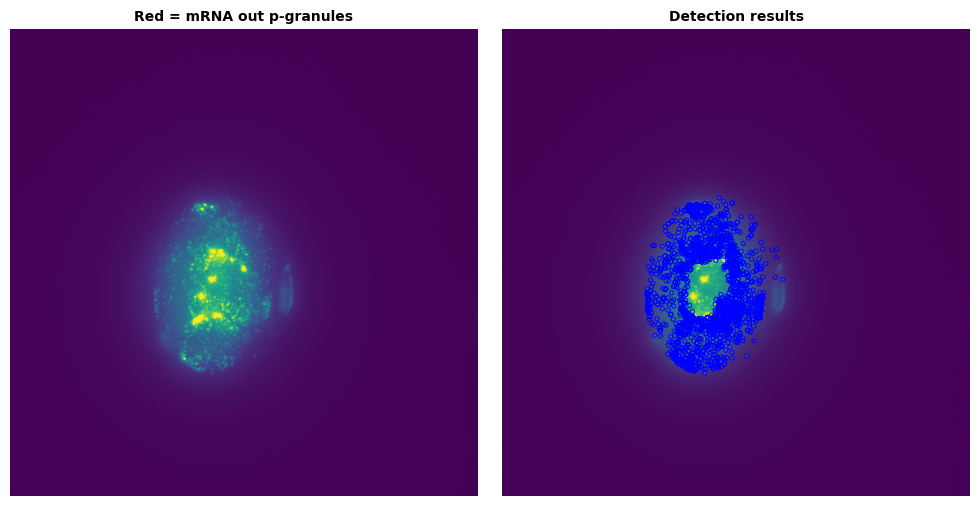

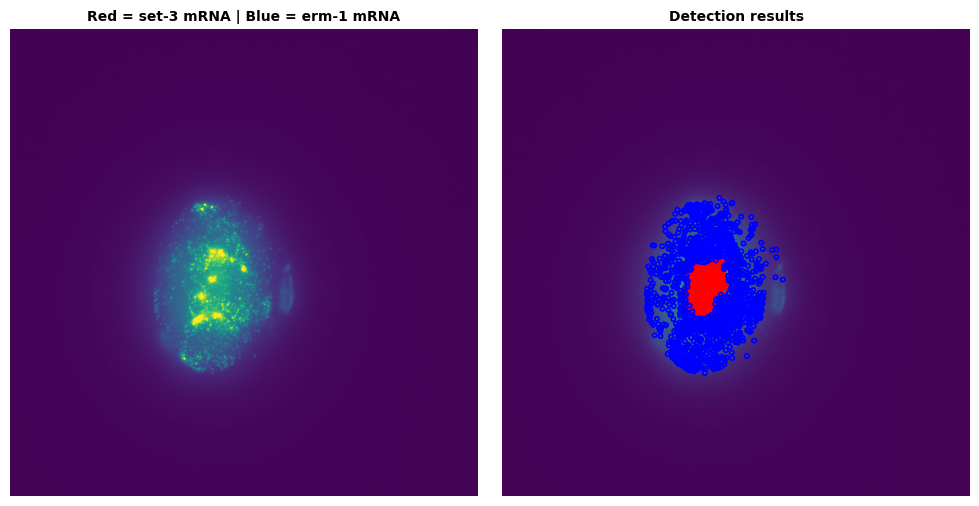

In [27]:
#Code to visualize colocalization with p granules

mask = masks_pgranules
coord = ch1_array
ndim = 3

spots_in_pgranules, spots_out_pgranules = bigfish.multistack.identify_objects_in_region(mask, coord, ndim)

# spots_in, spots_out = multistack.identify_objects_in_region(nuc_label, spots, ndim=3)
print("detected spots (inside p-granules)")
print("\r shape: {0}".format(spots_in_pgranules.shape))
print("\r dtype: {0}".format(spots_in_pgranules.dtype), "\n")
print("detected spots (outside p-granules)")
print("\r shape: {0}".format(spots_out_pgranules.shape))
print("\r dtype: {0}".format(spots_out_pgranules.dtype))



in_pgranules_output = os.path.join(output_folder, mCherry + '_in_pgranules_output_' + image_name + '.png')

# plot
plot.plot_detection(
    mask,
    spots=spots_in_pgranules, 
    radius=1, 
    color="red",
    path_output= in_pgranules_output,
    title="Red = mRNA in p-granules",
    linewidth=3, contrast=True, framesize=(10, 5))

out_pgranules_output = os.path.join(output_folder, mCherry + '_out_pgranules_output_' + image_name + '.png')

# plot
plot.plot_detection(
    rna_max_ch1,
    spots=spots_out_pgranules, 
    radius=1, 
    color="blue",
     path_output= out_pgranules_output,
    title="Red = mRNA out p-granules",
    linewidth=3, contrast=True, framesize=(10, 5))

combined_pgranules_output = os.path.join(output_folder, mCherry + '_combined_pgranules_output_' + image_name + '.png')

# plot
plot.plot_detection(
    rna_max_ch1,
    spots=[spots_in_pgranules, spots_out_pgranules], 
    radius=2, 
    path_output= combined_pgranules_output,
    color=["red", "blue"],
    title=f"Red = {Cy5} | Blue = {mCherry}",
    linewidth=3, contrast=True, framesize=(10, 5))

In [28]:
# Quantification: number of spots in nuclei and cytoplasm
num_spots_in_nuclei = spots_in_pgranules.shape[0]
# num_spots_in_cyto = spots_out_pgranules.shape[0]

# Add new columns with default values (e.g., NaN)
df_quantification[f'{mCherry} in pgranules'] = np.nan
# df_quantification['mCherry_out_pgranules'] = np.nan

# Update the new columns with the counts for the specific image ID
df_quantification.loc[df_quantification['Image ID'] == image_name, f'{mCherry} in pgranules'] = num_spots_in_nuclei
# df_quantification.loc[df_quantification['Image ID'] == image_name, 'mCherry_out_pgranules'] = num_spots_in_cyto

# Display the updated DataFrame
df_quantification


,Image ID,set-3 mRNA molecules,erm-1 mRNA molecules,erm-1 mRNA in membranes,erm-1 mRNA in nuclei,erm-1 mRNA in pgranules
0,240820_wLP017_L4440_03,924,2815,1107.0,562.0,953.0


#### 3.4 mRNA-mRNA colocalization (FLARIM - translating mRNAs)

colocalized spots
Distances: (1,)


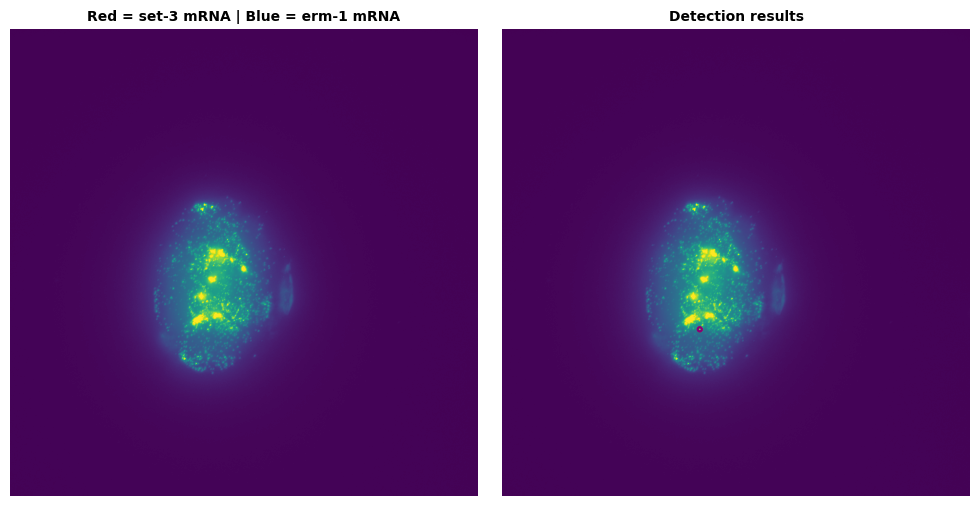

In [29]:
def mRNA_coloc(ch0_array, ch1_array, voxel_size, rna_max_ch1, output_folder, image_name, Cy5, mCherry, plot):
    # Set threshold and detect co-localized spots
    threshold = 5
    colocalized_spots = []
    (
        colocalized_spots_ch0, 
        colocalized_spots_ch1, 
        distances, 
        indices_1, 
        indices_2, 
        threshold
    ) = multistack.detect_spots_colocalization(
        spots_1=ch0_array,
        spots_2=ch1_array,
        voxel_size=voxel_size,
        threshold=threshold,
        return_indices=True,
        return_threshold=True
    )

    # Print details of the co-localized spots
    print("colocalized spots")
    print(f"Distances: {distances.shape}")
    # print(f"Threshold: {threshold:0.2f} nm")

    # Define output filename
    mRNA_mRNA_output = os.path.join(output_folder, f"mRNA_coloc_mRNA_{image_name}.png")

    # Plot and save the figure
    plot.plot_detection(
        rna_max_ch1,
        spots=[colocalized_spots_ch0, colocalized_spots_ch1], 
        radius=2, 
        path_output=mRNA_mRNA_output,
        color=["red", "purple"],
        title=f"Red = {Cy5} | Blue = {mCherry}",
        linewidth=3, contrast=True, framesize=(10, 5)
    )

# Call the function
mRNA_coloc(ch0_array, ch1_array, voxel_size, rna_max_ch1, output_folder, image_name, Cy5, mCherry, plot)



# #610 channel dual spot overlay 
# print(f"spot detection overlay on {mCherry} image")
# print(f"{mCherry} spot count: {ch1_array.shape}")
# plot.plot_detection(
#     rna_max_ch1,
#     spots=[ch0_array, ch1_array], 
#     radius=1, 
#     color=["red", "blue"],
#     title=f"Red = {Cy5} | Blue = {mCherry}",
#     linewidth=3, 
#     contrast=True, 
#     framesize=(10, 5)
# )


#### 3.5 Log calculation of mRNA vs protein

/tmp/ipykernel_3110894/4151659237.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('CMRmap').copy()


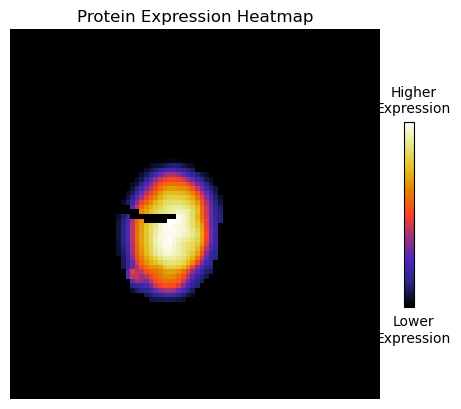

In [30]:
# Heatmap of protein levels with intensity calculations restricted to the mask

fitc_projection = np.max(image_colors[2, :, :, :], axis=0)

def protein_expression(intensity_image, mask, output_filename, title='Protein Expression Heatmap', grid_width=80, grid_height=80):
    # Calculate the width and height of each grid cell
    img_width, img_height = intensity_image.shape[1], intensity_image.shape[0]
    cell_width = img_width / grid_width
    cell_height = img_height / grid_height

    # Create an empty grid to store the mean intensities
    grid = np.zeros((grid_height, grid_width), dtype=float)

    # Populate the grid with mean intensities within the mask
    for i in range(grid_height):
        for j in range(grid_width):
            # Determine the boundaries of the current grid cell
            x_start = int(j * cell_width)
            x_end = int((j + 1) * cell_width)
            y_start = int(i * cell_height)
            y_end = int((i + 1) * cell_height)

            # Extract the subregion of the intensity image and the mask
            region_intensity = intensity_image[y_start:y_end, x_start:x_end]
            region_mask = mask[y_start:y_end, x_start:x_end]

            # Calculate the mean intensity only inside the mask
            if np.any(region_mask):
                grid[i, j] = np.mean(region_intensity[region_mask > 0])
            else:
                grid[i, j] = np.nan  # Set to NaN if no mask is present in the region

    # Create a colormap that handles NaN values by setting them to black
    cmap = plt.cm.get_cmap('CMRmap').copy()
    cmap.set_bad(color='black')  # Set NaN values to black

    # Create a heatmap, handling NaN values by setting them to black
    masked_grid = np.ma.masked_invalid(grid)  # Mask NaN values
    plt.imshow(masked_grid, cmap=cmap, interpolation='nearest', vmin=np.nanmin(grid), vmax=np.nanmax(grid))
    plt.title(title)
    plt.axis('off')

    # Create a vertical color bar
    cbar = plt.colorbar(orientation='vertical', shrink=0.5)  # Adjust the shrink parameter to make it smaller
    cbar.ax.text(1, 1.05, 'Higher\nExpression', transform=cbar.ax.transAxes, ha='center')
    cbar.ax.text(1, -0.19, 'Lower\nExpression', transform=cbar.ax.transAxes, ha='center')
    cbar.set_ticks([])

    # Save the heatmap
    plt.savefig(output_filename)
    plt.show()

# Example usage with mask and intensity projection
if fitc_projection is not None and masks_cytosol is not None:
    protein_expression(fitc_projection, masks_cytosol, os.path.join(output_folder, 'FITC_protein_expression_heatmap.png'))


/tmp/ipykernel_3110894/3857781388.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_with_black = plt.cm.get_cmap(cmap).copy()


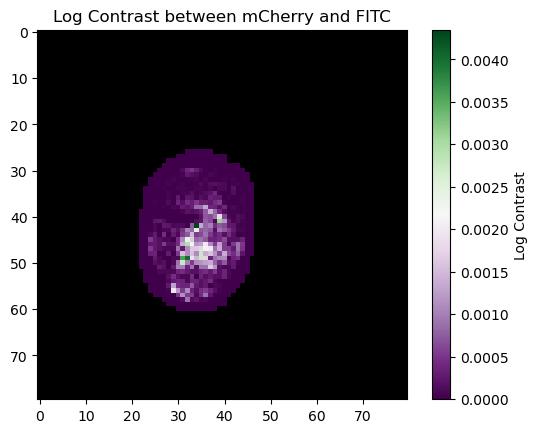

In [31]:
# Define a custom colormap from black to white to green, ensuring NaN values appear as black
cmap = 'PRGn'
cmap_with_black = plt.cm.get_cmap(cmap).copy()
cmap_with_black.set_bad(color='black')  # Set NaN values to black

def log_contrast(mcherry_heatmap, fitc_projection, masks_cytosol, cmap=cmap_with_black):
    # Resize the cytosol mask to match the mcherry_heatmap dimensions
    masks_cytosol_resized = resize(masks_cytosol, mcherry_heatmap.shape, anti_aliasing=True)
    
    # Apply the resized cytosol mask to both mcherry_heatmap and fitc_projection
    mcherry_heatmap_masked = mcherry_heatmap * masks_cytosol_resized
    fitc_projection_masked = fitc_projection * masks_cytosol_resized

    # Initialize log contrast map with NaN values
    log_contrast_map = np.full(mcherry_heatmap.shape, np.nan)

    # Calculate the log contrast only inside the mask (where the mask is > 0)
    mask_inside = masks_cytosol_resized > 0

    # Calculate log contrast, avoiding log(0) issues, only inside the mask
    if np.any(mask_inside):
        log_contrast_map[mask_inside] = np.log1p(mcherry_heatmap_masked[mask_inside]) - np.log1p(fitc_projection_masked[mask_inside])

    # Mask NaN values in the log contrast map to ensure they appear as black
    masked_contrast_map = np.ma.masked_invalid(log_contrast_map)
    
    # Plot the log contrast map, handling NaN values by setting them to black
    plt.imshow(masked_contrast_map, cmap=cmap, interpolation='nearest', vmin=np.nanmin(log_contrast_map), vmax=np.nanmax(log_contrast_map))
    plt.colorbar(label='Log Contrast')
    plt.title('Log Contrast between mCherry and FITC')
    plt.show()
    
    return log_contrast_map

# Example usage
fitc_resized = resize(fitc_projection, mcherry_heatmap.shape, anti_aliasing=True)
log_contrast_map = log_contrast(mcherry_heatmap, fitc_resized, masks_cytosol)


### 4. Data export and display

In [32]:
#pdf report

#Specify the size of items in the report

output_pdf_path = os.path.join(output_folder, "report.pdf")

def create_image_report(output_folder, output_pdf_path, additional_info="", crop_top=0):
    image_files = [f for f in os.listdir(output_folder) if f.endswith(".png")]

    # Create a PDF document
    pdf_path = output_pdf_path
    c = canvas.Canvas(pdf_path, pagesize=letter)

    # Add additional information to the report
    if additional_info:
        c.drawString(100, 750, additional_info)

    # Set initial coordinates for the first image
    x_coordinate = -50
    y_coordinate = 525

    # Set the vertical spacing between rows
    row_spacing = 140

    # Reverse the order of image_files
    image_files.reverse()

    # Loop through each image and add it to the PDF
    for image_file in image_files:
        image_path = os.path.join(output_folder, image_file)

        # Convert the PNG image to PDF using PIL
        img = Image.open(image_path)

        # Crop the top of the image
        img = img.crop((0, crop_top, img.width, img.height))

        # Draw the image at the current coordinates
        c.drawInlineImage(img, x_coordinate, y_coordinate, width=700, height=200)

        # Update the coordinates for the next image in the same row
        x_coordinate += 700 + 20  # Add space between images

        # Check if a new row is needed
        if x_coordinate > 500:
            x_coordinate = -50
            y_coordinate -= row_spacing  # Move to the next row

        # Add a new page if needed (you might want to adjust this condition based on your preference)
        if y_coordinate < 50:
            c.showPage()
            x_coordinate = -50
            y_coordinate = 595 - row_spacing  # Move to the next row

    # Save the PDF
    c.save()
    print(f"PDF report created: {pdf_path}")

from datetime import date

# Example usage with cropping 50 pixels from the top of each image
report_name = f'Report-{date.today()}'
create_image_report(output_folder, output_pdf_path, report_name, crop_top=60)



PDF report created: /pl/active/onishimura_lab/PROJECTS/naly/bigfish/01_RNAi_quantification/wLP017-ERM-1/wLP017_L4440_RNAi/240820_wLP017_L4440_erm-1_set-3-rep1/input/03_results/report.pdf
